<a href="https://colab.research.google.com/github/dajebbar/Predicting-Medical-Expenses-using-Linear-Regression/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Medical Expenses using Linear Regression

# Description

ACME data set containing verified historical data, consisting of the information and the actual medical charges incurred by over 1300 customers.


# Goal
Creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.  
Estimates from the system will be used to determine the annual insurance premium (amount paid every month) offered to the customer.


## Downloading the Data

To begin, let's download the data using the `urlretrieve` function from `urllib.request`.

In [1]:
url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [2]:
from urllib.request import urlretrieve

In [3]:
urlretrieve(url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x7f1f40ff4650>)

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
medical_df = pd.read_csv('medical.csv')
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
medical_df.shape

(1338, 7)

The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [7]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [8]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization. Follow these tutorials to learn how to use these libraries: 

- https://jovian.ai/aakashns/python-matplotlib-data-visualization
- https://jovian.ai/aakashns/interactive-visualization-plotly
- https://jovian.ai/aakashns/dataviz-cheatsheet

The following settings will improve the default style and font sizes for our charts.

In [9]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [10]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [11]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.



### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [12]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measure of body masse index (BMI) seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)


### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [13]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \$7300, the median for smokers is close to \$35,000.

### Charges compared to sex

In [14]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='sex', 
                   color_discrete_sequence=['pink', 'blue'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

## charge compared to region

In [15]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='region', 
                   #color_discrete_sequence=['yello', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [16]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [17]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [18]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [19]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

In [20]:
fig = px.violin(medical_df, 
                 x='sex', 
                 y='charges', 
                 )
fig.update_traces(marker_size=5)
fig.show()

In [21]:
fig = px.violin(medical_df, 
                 x='smoker', 
                 y='charges', 
                 )
fig.update_traces(marker_size=5)
fig.show()

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [22]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [23]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [24]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.787251430498478




Here's how correlation coefficients can be interpreted ([source](https://statisticsbyjim.com/basics/correlations)):

* **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.

    * The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

    * A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.
    
    * When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.


* **Direction**: The sign of the correlation coefficient represents the direction of the relationship.

    * Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.
    
    * Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually ([source](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

<img src="https://i.imgur.com/3XUpDlw.png" width="360">

The correlation coefficient has the following formula:

<img src="https://i.imgur.com/unapugP.png" width="360">

You can learn more about the mathematical definition and geometric interpretation of correlation here: https://www.youtube.com/watch?v=xZ_z8KWkhXE

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

In [25]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

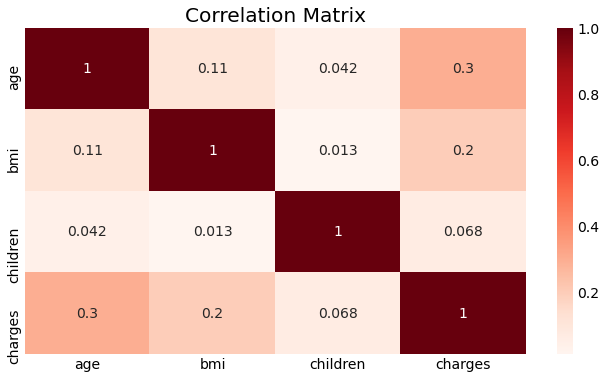

In [26]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

## Linear Regression using a Single Feature

We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [27]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Next, let's visualize the relationship between "age" and "charges"

Text(0.5, 1.0, 'Age vs. Charges')

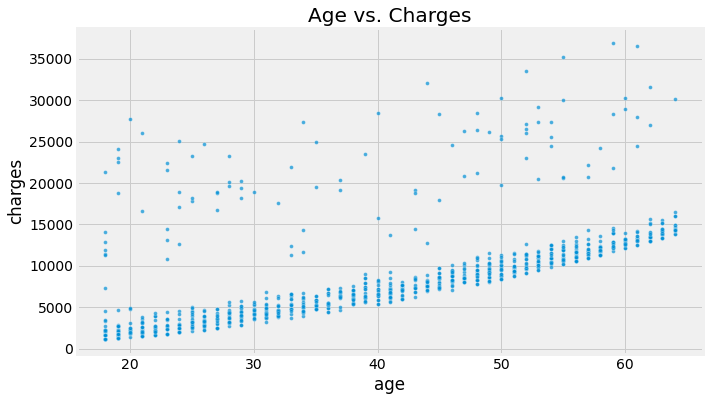

In [28]:
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15)
plt.title('Age vs. Charges')

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept"). 

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:

$charges = w \times age + b$

We'll try determine $w$ and $b$ for the line that best fits the data. 

* This technique is called _linear regression_, and we call the above equation a _linear regression model_, because it models the relationship between "age" and "charges" as a straight line. 

* The numbers $w$ and $b$ are called the _parameters_ or _weights_ of the model.

* The values in the "age" column of the dataset are called the _inputs_ to the model and the values in the charges column are called "targets". 

Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.


In [29]:
def estimate_charges(age, w, b):
    return w * age + b

The `estimate_charges` function is our very first _model_.

Let's _guess_ the values for $w$ and $b$ and use them to estimate the value for charges.

In [30]:
w = 50
b = 100

In [31]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

We can plot the estimated charges using a line graph.

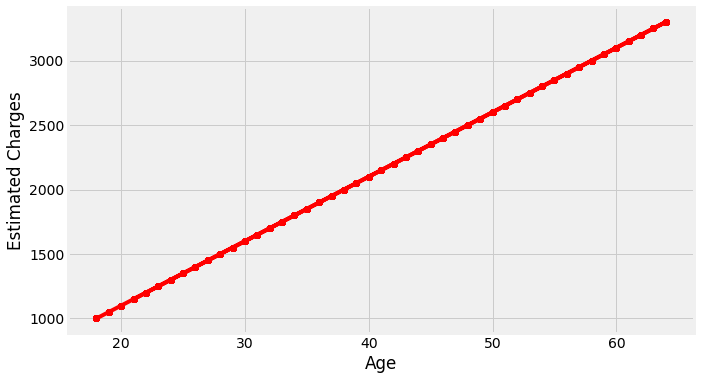

In [32]:
plt.plot(ages, estimated_charges, 'r-o')
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

As expected, the points lie on a straight line. 

We can overlay this line on the actual data, so see how well our _model_ fits the _data_.

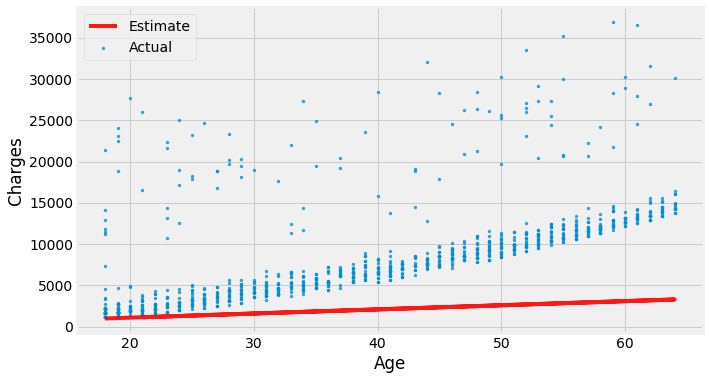

In [33]:
target = non_smoker_df.charges
plt.plot(ages, estimated_charges, 'r', alpha=.9)
plt.scatter(ages, target, s=8, alpha=.8)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.legend(['Estimate', 'Actual'])

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of $w$ and $b$ to move the line around. Let's define a helper function `try_parameters` which takes `w` and `b` as inputs and creates the above plot.

In [34]:
def try_parameters(w, b):
  ages = non_smoker_df.age
  target = non_smoker_df.charges

  estimated_charges = estimate_charges(ages, w, b)
  
  plt.plot(ages, estimated_charges, 'r', alpha=.9)
  plt.scatter(ages, target, s=8, alpha=.8)
  plt.xlabel("Age")
  plt.ylabel("Charges")
  plt.legend(['Estimate', 'Actual'])


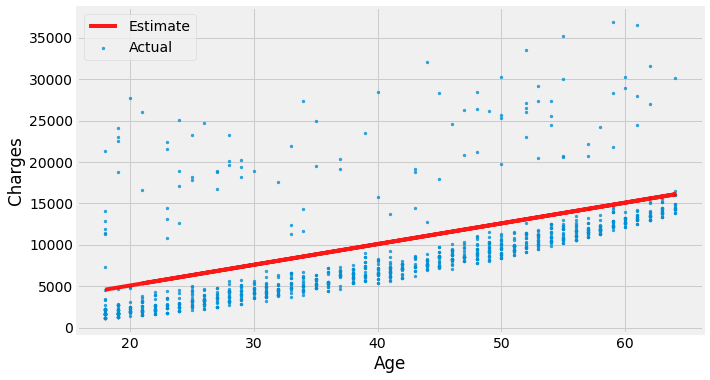

In [35]:
try_parameters(250, 100)

As we change the values, of $w$ and $b$ manually, trying to move the line visually closer to the points, we are _learning_ the approximate relationship between "age" and "charges". 

Wouldn't it be nice if a computer could try several different values of `w` and `b` and _learn_ the relationship between "age" and "charges"? To do this, we need to solve a couple of problems:

1. We need a way to measure numerically how well the line fits the points.

2. Once the "measure of fit" has been computed, we need a way to modify `w` and `b` to improve the the fit.

If we can solve the above problems, it should be possible for a computer to determine `w` and `b` for the best fit line, starting from a random guess.

### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows: 

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Geometrically, the residuals can be visualized as follows:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Let's define a function to compute the RMSE.

In [36]:
def rmse(target, prediction):
  return np.sqrt(np.mean((prediction - target)**2 ))

In [37]:
w = 250
b = 100

In [38]:
target = non_smoker_df.charges
predicted = estimate_charges(non_smoker_df.age, w, b)

In [39]:
rmse(target, predicted)

4907.571788102451

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by \$4907*. 

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.

In [40]:
def try_parameters(w, b):
  ages = non_smoker_df.age
  target = non_smoker_df.charges
  # predicted
  estimated_charges = estimate_charges(ages, w, b)

  plt.plot(ages, estimated_charges, 'r', alpha=.9)
  plt.scatter(ages, target, s=8, alpha=.8)
  plt.xlabel("Age")
  plt.ylabel("Charges")
  plt.legend(['Estimate', 'Actual'])

  loss = rmse(target, estimated_charges)
  print("RMSE Loss: ", loss)

RMSE Loss:  4801.455270374759


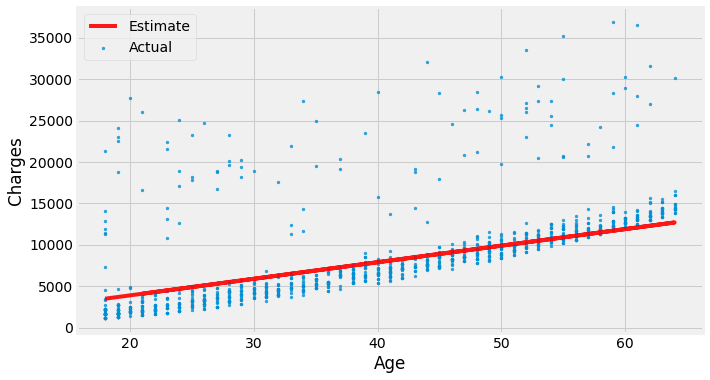

In [41]:
try_parameters(200, -90)

### Optimizer

Next, we need a strategy to modify weights `w` and `b` to reduce the loss and improve the "fit" of the line to the data.

* Ordinary Least Squares: https://www.youtube.com/watch?v=szXbuO3bVRk (better for smaller datasets)
* Stochastic gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 (better for larger datasets)

Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for `w` and `b` using matrix operations, while gradient descent uses a iterative approach, starting with a random values of `w` and `b` and slowly improving them using derivatives. 

Here's a visualization of how gradient descent works:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Doesn't it look similar to our own strategy of gradually moving the line closer to the points?



### Linear Regression using Scikit-learn

In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you. 

Let's use the `LinearRegression` class from `scikit-learn` to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [42]:
from sklearn.linear_model import LinearRegression

First, we create a new model object.

In [43]:
model = LinearRegression()

In [44]:
help(model)

Help on LinearRegression in module sklearn.linear_model._base object:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, optional, default True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      sub

Now that the input `X` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [45]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


Let's fit the model to the data.

In [46]:
model.fit(inputs, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61

In [47]:
model.predict(np.array(
    [
     [23],
    [37],
    [61]
    ]
))

array([ 4055.30443855,  7796.78921819, 14210.76312614])


Let compute the predictions for the entire set of inputs

In [48]:
predictions = model.predict(inputs)

In [49]:
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Let's compute the RMSE loss to evaluate the model.

In [50]:
rmse(targets, predictions)

4662.505766636391

Seems like our prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

The parameters of the model are stored in the `coef_` and `intercept_` properties.

In [51]:
# w
model.coef_

array([267.24891283])

In [52]:
# b
model.intercept_

-2091.4205565650864

Are these parameters close to your best guesses?

Let's visualize the line created by the above parameters.

RMSE Loss:  4662.505766636391


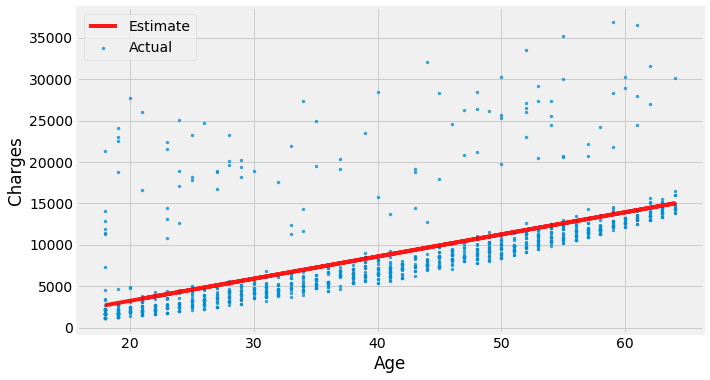

In [53]:
try_parameters(model.coef_, model.intercept_)

 The [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) class from `scikit-learn` to train a model using the stochastic gradient descent technique to make predictions and compute the loss.

In [54]:
# inputs = non_smoker_df[['age']]
# targets = non_smoker_df.charges
import sklearn.linear_model as lr
clf = lr.SGDRegressor()
clf.fit(inputs, targets)

# clf is a trained model
y_predicted = clf.predict(inputs)

In [55]:
sgd_rsme = rmse(targets, y_predicted)
sgd_rsme

4763.380104649546

RMSE Loss:  4763.380104649546


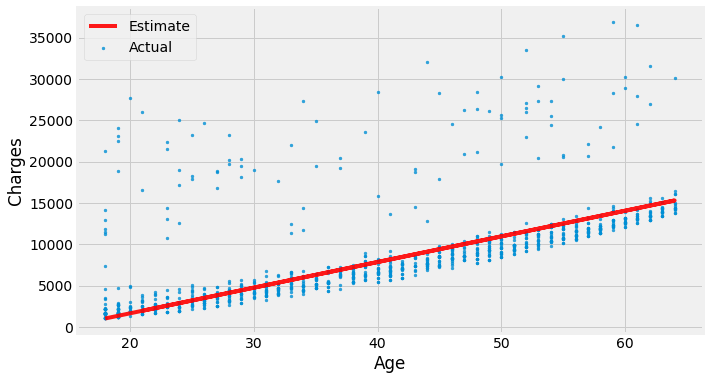

In [56]:
try_parameters(clf.coef_, clf.intercept_)

### Train a linear regression model to estimate medical charges for smokers.

In [57]:
smoker_df = medical_df[medical_df.smoker == 'yes']

In [58]:
def try_parameters(w, b):
  ages = smoker_df.age
  target = smoker_df.charges
  # predicted
  estimated_charges = estimate_charges(ages, w, b)

  plt.plot(ages, estimated_charges, 'r', alpha=.9)
  plt.scatter(ages, target, s=8, alpha=.8)
  plt.xlabel("Age")
  plt.ylabel("Charges")
  plt.legend(['Estimate', 'Actual'])

  loss = rmse(target, estimated_charges)
  print("RMSE Loss: ", loss)

RMSE Loss:  24968.737476697133


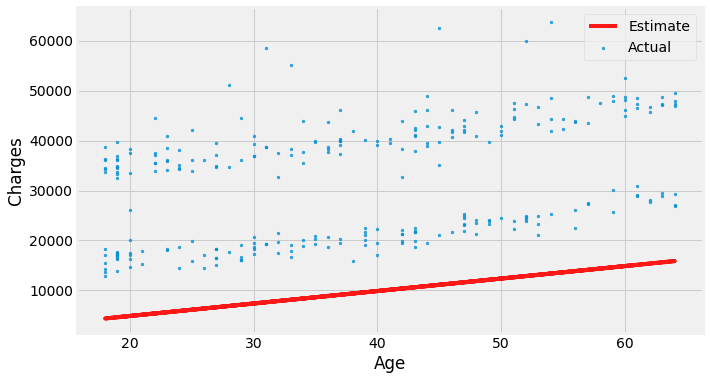

In [59]:
try_parameters(250, -120)

### The model

In [60]:
# Create inputs and targets
inputs, targets = smoker_df[['age']], smoker_df['charges']

In [61]:
# Create and train the model
model = LinearRegression().fit(inputs, targets)

In [62]:
# Generate predictions
predictions = model.predict(inputs)

In [64]:
# Compute loss to evalute the model
loss = rmse(targets, predictions)

In [65]:
loss

10711.00334810241

RMSE Loss:  10711.00334810241


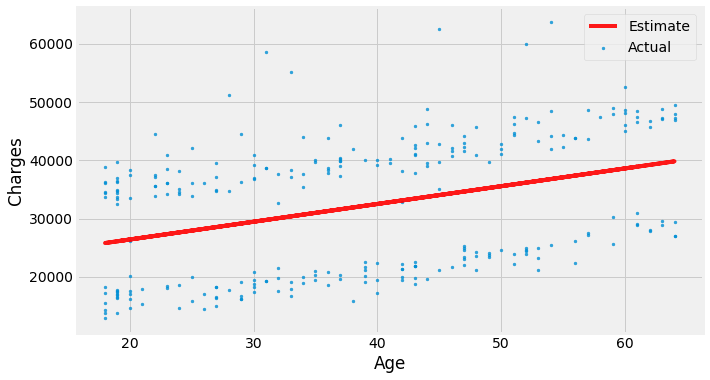

In [66]:
try_parameters(model.coef_, model.intercept_)

## Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

$charges = w_1 \times age + w_2 \times bmi + b$

We need to change just one line of code to include the BMI.

In [68]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)

In [69]:
print(f"Loss: {loss}")

Loss: 4662.312835461298


As you can see, adding the BMI doesn't seem to reduce the loss by much, as the BMI has a very weak correlation with charges, especially for non smokers.

In [70]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.08403654312833268

In [71]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can also visualize the relationship between all 3 variables "age", "bmi" and "charges" using a 3D scatter plot.

In [72]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()